In [19]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import json, csv
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences


import matplotlib.pyplot as plt
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.combine import SMOTEENN

In [2]:
with open('C:/Users/agkat/Documents/College/1. SML/A1/domain1_train.json', 'r') as file:
   domain1_data = [json.loads(line) for line in file]

with open('C:/Users/agkat/Documents/College/1. SML/A1/domain2_train.json', 'r') as file:
    domain2_data = [json.loads(line) for line in file]


# Split data into Testing and Validation sets

In [3]:
# Separate the text and labels
X1 = pad_sequences([instance['text'] for instance in domain1_data], padding='post', value=0, maxlen=1075)
Y1 = [instance['label'] for instance in domain1_data]

X2 = pad_sequences([instance['text'] for instance in domain2_data], padding='post', value=0, maxlen=1075)
Y2 = [instance['label'] for instance in domain2_data]

In [65]:
# Split the data into training and validation sets
# TrainX1, ValX1, TrainY1, ValY1 = train_test_split(X1, Y1, train_size=6283, random_state=42)
TrainX2, ValX2, TrainY2, ValY2 = train_test_split(X2, Y2, test_size=0.2, random_state=42)

In [ ]:
TrainX1, ValX1, TrainY1, ValY1 = train_test_split(X1, Y1, train_size=6283, random_state=42)

In [66]:
np.array(TrainX1)

array([[   0,  188,  667, ...,    0,    0,    0],
       [   0,  126,    1, ...,    0,    0,    0],
       [   0,    3, 2802, ...,    0,    0,    0],
       ...,
       [   0,  833,    0, ...,    0,    0,    0],
       [  58, 1111,    4, ...,    0,    0,    0],
       [   2,   48,  124, ...,    0,    0,    0]])

## Nearest Neighbours are Edited here

In [67]:
c = [TrainY2]
for n in range(1, 10):
    enn = EditedNearestNeighbours(n_neighbors=n, sampling_strategy='majority')
    X_train_enn, y_train_enn = enn.fit_resample(TrainX2, TrainY2)
    c.append(y_train_enn)
    


KeyboardInterrupt: 

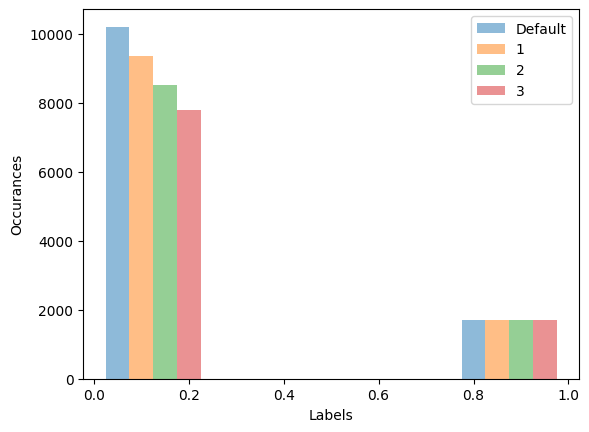

In [68]:
# c.append(TrainY2)
plt.hist(c, np.linspace(0, 1, 5), alpha=0.5, label=['Default',1,2,3,4,5,6,7,8,9,10,'Default'], )
#plt.hist(, np.linspace(0, 1, 4), alpha=0.5, label='Default')
plt.xlabel('Labels')
plt.ylabel('Occurances')
plt.legend()
plt.show()


In [69]:
enn = EditedNearestNeighbours(n_neighbors=9, sampling_strategy='majority')
X_train_enn, y_train_enn = enn.fit_resample(TrainX2, TrainY2)

In [71]:
len(X_train_enn)

6283

## Training sets 

### Domain 1
- TrainX1 
- TrainY1

### Domain 2
- X_train_enn
- y_train_enn

## Validation sets

### Domain 1
- ValX1
- ValY1

### Domain 2
- ValX2
- ValY2

## Training sets 

### Domain 1
- TrainX1 
- TrainY1

### Domain 2
- X_train_enn
- y_train_enn

## Validation sets

### Domain 1
- ValX1
- ValY1

### Domain 2
- ValX2
- ValY2

# Multi Task Learner

In [258]:
import tensorflow as tf

d1i = tf.keras.layers.Input(shape=(1075, ), name='d1')
d2i = tf.keras.layers.Input(shape=(1075, ), name='d2')

integer_lookup = tf.keras.layers.IntegerLookup(vocabulary=list(range(0,5000)))
domain1_task = integer_lookup(d1i)
domain2_task = integer_lookup(d2i)

# Shared layers
for i in range(8): 
    shared_layer = tf.keras.layers.Dense(16, activation='relu')
    domain1_task = shared_layer(domain1_task)
    domain2_task = shared_layer(domain2_task)

# Indiv layers
for i in range(4):
    domain1_task = tf.keras.layers.Dense(8, activation='relu')(domain1_task)
    domain2_task = tf.keras.layers.Dense(8, activation='relu')(domain2_task)


# Final result layer

domain1_task = tf.keras.layers.Dense(1, activation='sigmoid', name='D1O')(domain1_task)
domain2_task = tf.keras.layers.Dense(1, activation='sigmoid', name='D2O')(domain2_task)


model = tf.keras.Model(inputs = [d1i, d2i], outputs = [domain1_task, domain2_task])


In [259]:
TrainX1 = np.array(TrainX1)
TrainY1 = np.array(TrainY1)

X_train_enn = np.array(X_train_enn)
y_train_enn = np.array(y_train_enn)

In [260]:

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit([TrainX1, X_train_enn], [TrainY1, y_train_enn], epochs=10, verbose=0)

# Make predictions
# predictions = model.predict(X2)

In [261]:
ValX = np.concatenate((ValX1, ValX2), axis=0)
ValY = np.concatenate((ValY1, ValY2), axis=0)

In [262]:
from sklearn.metrics import accuracy_score
predictions = model.predict([ValX, ValX])


507/507 [==============================] - 2s 4ms/step


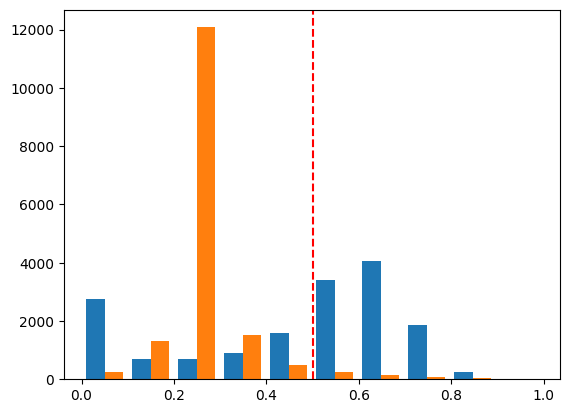

In [263]:
p0 = [p[0] for p in predictions[0]]
p1 = [p[0] for p in predictions[1]]

f,ax = plt.subplots()
# plt.scatter(range(len(p0)), p0, alpha=0.5, marker='.', s=10, label='Task 1')
# plt.scatter(range(len(p1)), p1, alpha=0.5, marker='.', s=10, label='Task 2')
ax.hist([p0, p1])
ax.axvline(x=0.5, linestyle='--', c='red')
# plt.legend()
plt.show()

In [264]:
mAp, mBp = predictions
preds = []
for i in range(len(mAp)):
    dA = abs(mAp[i][0] - 0.5)
    dB = abs(mBp[i][0] - 0.5)
    if dA < dB: 
        preds.append(mAp[i][0])
    else:
        preds.append(mBp[i][0])

In [265]:
preds = [1 if p >= 0.5 else 0 for p in preds]

In [266]:
accuracy_score(preds, ValY)

0.6378959066493796